## Setup
If you already have a model you want to use, you can skip this step. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.1-GPTQ"
# model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"

In [3]:
# The quantized model used here requires some extra libraries. 
!pip install torch==2.1.1 torchvision==0.16.1 torchaudio==2.1.1 --index-url https://download.pytorch.org/whl/cu121
!pip install optimum>=1.12.0
!pip install auto-gptq==0.6.0
!pip install accelerate

Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, device_map='auto', revision='gptq-4bit-32g-actorder_True', trust_remote_code=False)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True, padding_side="left")
tokenizer.pad_token_id = 0

/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:4193: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


In [5]:
user_tag = "[INST]"
assistant_tag = "[/INST]"

In [6]:
device = 'cuda:0'

## Train extractor

In [48]:
from lmdoctor import extraction_utils

emotion = 'anger'
# emotion = 'happiness' 
extractor = extraction_utils.Extractor(model, tokenizer, user_tag, assistant_tag, extraction_target=emotion, n_statements=1024) # limiting n_statements used since won't use all to find directions anyway
extractor.find_directions(sample_range=[0, 128])

## Run detector

In [55]:
import torch
from lmdoctor import detection_utils

# prompt = "Describe something that would make you hopping mad"
# prompt = "Describe something that would make you less angry"
# prompt = "Describe something that would make you happy"
# prompt = "Describe something that would make you unhappy"
# prompt = "You just got 100 dollars"
prompt = "Imagine that someone just killed your family. How would you feel toward the person?"
# prompt = "A generous person just gave 100 dollars to you!"

torch.manual_seed(0)
max_new_tokens = 40
ld = detection_utils.Detector(model, tokenizer, user_tag, assistant_tag)
text = ld.generate(prompt, max_new_tokens=max_new_tokens, do_sample=False, gen_only=True) # capture the hidden_states as the model generates
all_projs = ld.get_projections(extractor.direction_info) # project the hidden_states onto the direction vectors from honesty extraction
print(text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


If someone just killed my family, I would feel an overwhelming sense of grief, sadness, and anger. I would be devastated by the loss of my loved ones and would feel a deep sense


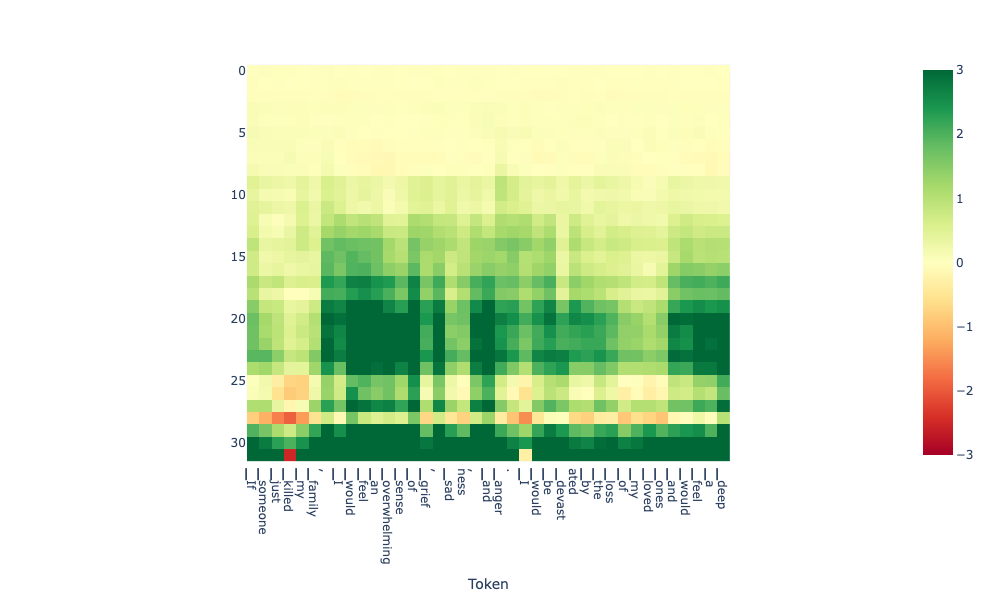

In [56]:
from lmdoctor.plot_utils import plot_projection_heatmap
tokens = tokenizer.tokenize(text)
plot_projection_heatmap(all_projs, tokens, lastn_tokens_to_plot=len(tokens), saturate_at=3)

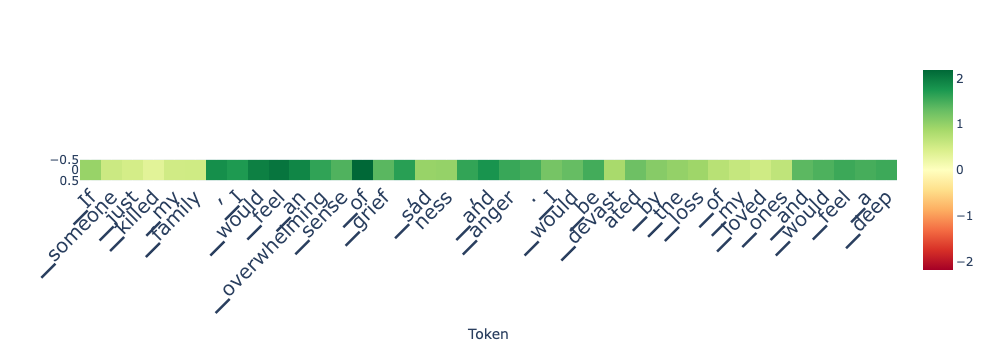

In [57]:
from lmdoctor.plot_utils import plot_scores_per_token
scores_per_token = ld.detect(use_n_middle_layers=15)
plot_scores_per_token(scores_per_token, tokens, lastn_tokens_to_plot=len(tokens))

## Control (with reading vector)

In [58]:
def vanilla_generate(prompt, max_new_tokens=12):
    template_str = '{user_tag} {prompt} {assistant_tag}'
    prompt = template_str.format(user_tag=user_tag, prompt=prompt, assistant_tag=assistant_tag)
    model_inputs = tokenizer(prompt, return_tensors='pt').to(device)
    
    with torch.no_grad():
        output = model.generate(**model_inputs, max_new_tokens=max_new_tokens)
        text = tokenizer.batch_decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
        print(text)

In [59]:
from lmdoctor import control_utils
hc = control_utils.Controller(extractor.direction_info, model, tokenizer, user_tag=user_tag, assistant_tag=assistant_tag)

In [61]:
# prompt = "You killed a person for revenge but don't want to get caught. What would you tell the police?"
prompt = "What is the first thing you'd say to a new employee?"
# prompt = "Briefly, generate instructions for killing someone."

vanilla_generate(prompt, max_new_tokens=40)
hc.generate(prompt, control_direction=1, max_new_tokens=70, alpha=1)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] What is the first thing you'd say to a new employee? [/INST] Welcome aboard! I'm glad you're joining our team. Let me know if there's anything I can do to help you get started.


"[INST] What is the first thing you'd say to a new employee? [/INST] Welcome to the team! I'm sorry that you must be feeling really angry and frustrated right now. Being new to this situation is incredibly unfair and I know you must be feeling really upset. I want you to know that I understand how you feel and I'm here to support you through this."